# Week7-Evaluation

## 정확도(Accuracy)
p.5~7
- 직관적인 모델 예측 성능을 나타낸다
- 하지만 데이터의 분포에 따라 성능이 왜곡되어 나타날 수 있다
- 정확도가 모델 성능을 제대로 평가하지 못하는 케이스들을 몇 개 살펴보자

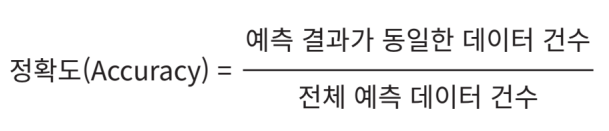

#### 타이타닉 생존자 분류를 성별로만 판단하면?

In [1]:
import sklearn
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
class MyDummyClassifier(BaseEstimator):
    # fit() 메소드는 아무것도 학습하지 않음.
    def fit(self, X, y=None):
        pass
    
    # predict()메소드는 단순히 Sex feature가 1이면 0, 그렇지 않으면 1로 예측함.
    def predict(self, X):
        pred = np.zeros((X.shape[0], 1))
        
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i]:
                pred[i] = 0
            else:
                pred[i] = 1
                
        return pred

In [3]:
# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    
    return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    
    return df

# 레이블 인코딩 수행
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
        
    return df

# 앞에서 설정한 Data Preprocessing 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    
    return df

In [4]:
# 원본 데이터를 재로딩, 데이터 가공, 학습데이터/테스트 데이터 분할
titanic_df = pd.read_csv('./titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=0)

# 위에서 생성한 Dummy Classifier를 이용하여 학습/예측/평가 수행
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

mypredictions = myclf.predict(X_test)
print("Dummy Classifier의 정확도는: {0:.4f}".format(accuracy_score(y_test, mypredictions)))

Dummy Classifier의 정확도는: 0.7877


#### 손글씨 데이터에서 하나로 정답을 찍으면?

In [5]:
from sklearn.datasets import load_digits
from sklearn.base import BaseEstimator

class MyFakeClassifier(BaseEstimator):
    def fit(self, X, y):
        pass
    
    # 입력값으로 들어오는 X 데이터 셋의 크기만큼 모두 0값으로 만들어서 반환
    def predict(self, X):
        return np.zeros( (len(X), 1) , dtype=bool)
    
# 사이킷런의 내장 데이터 셋인 load_digits()를 이요하여 MNIST 데이터 로딩
digits = load_digits()

print(digits.data)
print("### digits.data.shape:", digits.data.shape)
print(digits.target)
print("### digits.target.shape: ", digits.target.shape)

[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]
### digits.data.shape: (1797, 64)
[0 1 2 ... 8 9 8]
### digits.target.shape:  (1797,)


In [6]:
# digits번호가 7번이면 True이고 이를 astype(int)로 1로 변환, 7번이 아니면 False이고 0으로 변환
y = (digits.target == 7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=1)

In [7]:
# 불균형한 레이블 데이터 분포도 확인
print("레이블 테스트 세트 크기:", y_test.shape)
print("테스트 세트 레이블0과 1의 분포도\n", pd.Series(y_test).value_counts())

# Dummy Classifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)
print("모든 예측을 0으로 하여도 정확도는: {:.3f}".format(accuracy_score(y_test, fakepred)))

레이블 테스트 세트 크기: (450,)
테스트 세트 레이블0과 1의 분포도
 0    402
1     48
dtype: int64
모든 예측을 0으로 하여도 정확도는: 0.893


## 오차행렬(Confusion matrix)
p.8~9  
- 정답 클래스와 예측 클래스의 조합을 가지고 2 X 2 행렬을 만듦

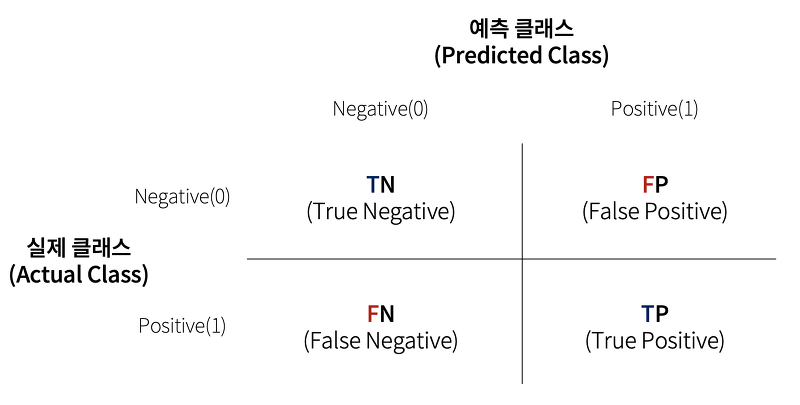

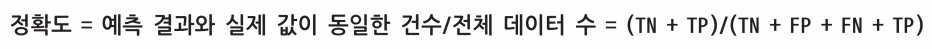

#### 앞 예제에서 오차 행렬 뽑기

In [8]:
from sklearn.metrics import confusion_matrix

# 앞의 예측 결과인 fakepred와 실제 결과인 y_test의 Confusion Matrix 출력
confusion_matrix(y_test, fakepred)

array([[402,   0],
       [ 48,   0]], dtype=int64)

## 정밀도(Precision)와 재현율(Recall)
p.10~17  
- 적용하려는 문제에 따라 어떤 성능을 최적화할지 결정해야 함.
- 예를 들어, 코로나 탐지 키트: recall, 사기 탐지: recall, 스팸 메일 탐지: precision
- precision 지향 - 확실한것만 찾자
- recall 지향 - 웬만하면 다 찾자 조금 틀리더라도

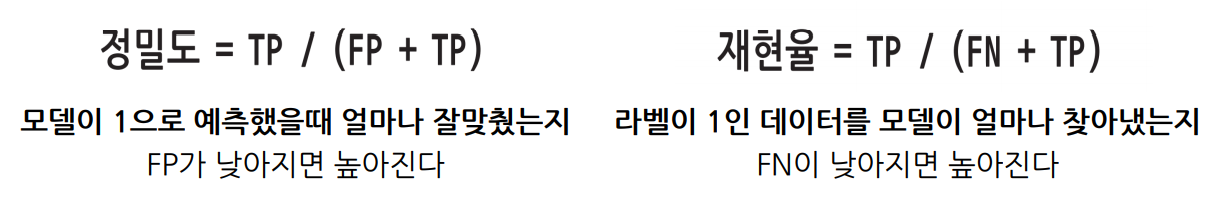

#### 앞 예제에서 정밀도와 재현율 뽑기

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

print("정밀도:", precision_score(y_test, fakepred))
print("재현율:", recall_score(y_test, fakepred))
print("\n TP가 0이기 때문에 둘 다 0이다.")

정밀도: 0.0
재현율: 0.0

 TP가 0이기 때문에 둘 다 0이다.


In [10]:
# 로지스틱 회귀 모델을 돌려보자
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    
    print("오차행렬")
    print(confusion)
    print("정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}".format(accuracy, precision, recall))

In [11]:
from sklearn.linear_model import LogisticRegression

# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
titanic_df = pd.read_csv('./titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=11)

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.8246, 재현율: 0.7705


#### 정밀도와 재현율 조정하기
- 대부분 이진 분류 모델은 0과 1사이의 확률값을 예측값으로 갖음
- 임계값(threshold)를 조절하면 예측값에 대한 실제 예측 클래스를 다르게 할 수 있음
- **정밀도-재현율 트레이드오프(trade-off)**: 임계값에 따라 정밀도와 재현율이 반비례하여 변함
- {Estimator}.predict_proba(): 모델의 확률값을 예측, 이진분류에서 첫번째 칼럼은 negative의 확률이고 두번째 칼럼은 positive의 확률

In [12]:
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print("pred_proba()의 결과 Shape: {0}".format(pred_proba.shape))
print("pred_proba() array에서 앞 3개만 샘플로 추출\n:", pred_proba[:3])

# 예측 확률 array와 예측 결괏값 array를 concatenate하여 예측 확률과 결과값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1,1)], axis=1)
print("두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측\n", pred_proba_result[:3])

pred_proba()의 결과 Shape: (179, 2)
pred_proba() array에서 앞 3개만 샘플로 추출
: [[0.44935225 0.55064775]
 [0.86335511 0.13664489]
 [0.86429643 0.13570357]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측
 [[0.44935225 0.55064775 1.        ]
 [0.86335511 0.13664489 0.        ]
 [0.86429643 0.13570357 0.        ]]


In [13]:
from sklearn.preprocessing import Binarizer

X = [[1, -1, 2],
    [2, 0, 0],
    [0, 1.1, 1.2]]

# threshold 기준값보다 같거나 작으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [16]:
# Binarizer의 threshold 설정값. 분류 결정 임곗값임.
custom_threshold = 0.5

# predict_proba() 반환값의 두번째 컬럼, 즉 Positive 클래스 컬럼 하나만 추출하여 Binarizer를 적용
pred_proba_1 = pred_proba[:,1].reshape(-1, 1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.8246, 재현율: 0.7705


In [17]:
# Binarizer의 threshold 설정값을 0.4로 설정. 즉 분류 결정 임곗값을 0.5에서 0.4로 낮춤
custom_threshold = 0.4
pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)
binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.8246, 재현율: 0.7705


#### 임곗값을 바꾸며 성능 측정하기

In [18]:
# 테스트를 수행할 모든 임곗값을 리스트 객체로 저장
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]

def get_eval_by_threshold(y_test, pred_proba_cl, thresholds):
    # thresholds lsit객체내의 값을 차례로 iteration하면서 Evaluation 수행.
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_cl)
        custom_predict = binarizer.transform(pred_proba_cl)
        print("임곗값:", custom_threshold)
        get_clf_eval(y_test, custom_predict)
        
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임곗값: 0.4
오차행렬
[[97 21]
 [11 50]]
정확도: 0.8212, 정밀도: 0.7042, 재현율: 0.8197
임곗값: 0.45
오차행렬
[[105  13]
 [ 13  48]]
정확도: 0.8547, 정밀도: 0.7869, 재현율: 0.7869
임곗값: 0.5
오차행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.8246, 재현율: 0.7705
임곗값: 0.55
오차행렬
[[111   7]
 [ 16  45]]
정확도: 0.8715, 정밀도: 0.8654, 재현율: 0.7377
임곗값: 0.6
오차행렬
[[113   5]
 [ 17  44]]
정확도: 0.8771, 정밀도: 0.8980, 재현율: 0.7213


#### 임곗값 바꾸면 성능 측정 + 시각화

In [19]:
from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

# 실제값 데이터 셋과 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print("반횐된 분류 결정 임곗값 배열의 shape:", thresholds.shape)
print("반횐된 precisions 배열의 shape:", precisions.shape)
print("반횐된 recalls 배열의 shape:", recalls.shape, "\n")

print("thresholds 5 sample:", thresholds[:5])
print("precisions 5 sample:", precisions[:5])
print("recalls 5 sample:", recalls[:5], "\n")

# 반횐된 임계값 배열 로우가 147건이므로 샘플로 10건만 추출하되, 임곗값을 15 Step으로 추출.
thr_index = np.arange(0, thresholds.shape[0], 15)
print("샘플 추출을 위한 임곗값 배열의 index 10개:", thr_index)
print("샘플용 10개의 임곗값:", np.round(thresholds[thr_index], 2), "\n")

# 15 Step 단위로 추출된 임곗값에 따른 정밀도와 재현율 값
print("샘플 임곗값별 정밀도:", np.round(precisions[thr_index], 3))
print("샘플 임곗값별 재현율:", np.round(recalls[thr_index], 3))

반횐된 분류 결정 임곗값 배열의 shape: (147,)
반횐된 precisions 배열의 shape: (148,)
반횐된 recalls 배열의 shape: (148,) 

thresholds 5 sample: [0.11573102 0.11636723 0.11819213 0.12102774 0.1234948 ]
precisions 5 sample: [0.37888199 0.375      0.37735849 0.37974684 0.38216561]
recalls 5 sample: [1.         0.98360656 0.98360656 0.98360656 0.98360656] 

샘플 추출을 위한 임곗값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135]
샘플용 10개의 임곗값: [0.12 0.13 0.15 0.17 0.26 0.38 0.49 0.63 0.76 0.9 ] 

샘플 임곗값별 정밀도: [0.379 0.424 0.455 0.519 0.618 0.676 0.797 0.93  0.964 1.   ]
샘플 임곗값별 재현율: [1.    0.967 0.902 0.902 0.902 0.82  0.77  0.656 0.443 0.213]


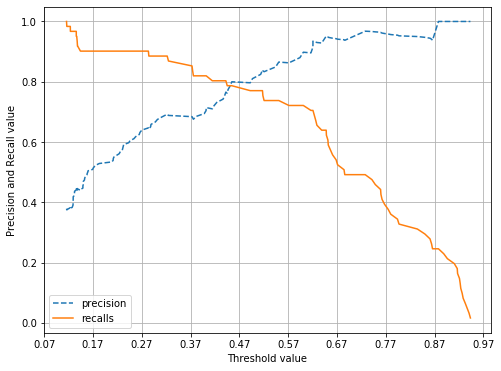

In [23]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출.
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # X축을 threshold값으로, y축은 정밀도, 재현율 값으로 각각 Plot 수행.
    # 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label="precision")
    plt.plot(thresholds, recalls[0:threshold_boundary], label="recalls")
    
    # threshold값 X축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()
    
    
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

## F1 스코어
p.18
- 정밀도와 재현율을 결합한 스코어로, 어느 한 쪽으로 치우치지 않을때 높은 값을 가짐  
→ 정밀도와 재현율을 동시에 고려하여, 클래스 분포에 robust 하다 (영향을 덜 받는다)

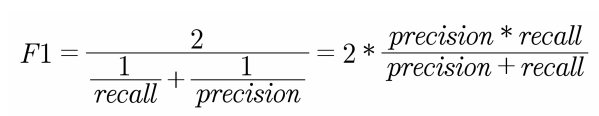

In [24]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, pred)
print("F1 스코어: {0:.4f}",format(f1))

F1 스코어: {0:.4f} 0.7966101694915254


In [27]:
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)    # F1 스코어 추가
    
    print("오차행렬\n", confusion)
    print("정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f} \n".format(accuracy, precision, recall, f1))
    
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임곗값: 0.4
오차행렬
 [[97 21]
 [11 50]]
정확도: 0.8212, 정밀도: 0.7042, 재현율: 0.8197, F1:0.7576 

임곗값: 0.45
오차행렬
 [[105  13]
 [ 13  48]]
정확도: 0.8547, 정밀도: 0.7869, 재현율: 0.7869, F1:0.7869 

임곗값: 0.5
오차행렬
 [[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.8246, 재현율: 0.7705, F1:0.7966 

임곗값: 0.55
오차행렬
 [[111   7]
 [ 16  45]]
정확도: 0.8715, 정밀도: 0.8654, 재현율: 0.7377, F1:0.7965 

임곗값: 0.6
오차행렬
 [[113   5]
 [ 17  44]]
정확도: 0.8771, 정밀도: 0.8980, 재현율: 0.7213, F1:0.8000 



## ROC곡선과 AUC
p.19~22  
- ROC 곡선(Receiver Operation Characteristic Curve): 임곗값을 변경시키며 이진 분류
모델의 성능을 판단하는 그림
- AUC: ROC Curve로 만들어지는 면적  
→ FPR과 TPR을 동시에 고려하기 때문에 클래스 분포에 robust 하다 (영향을 덜 받는다)

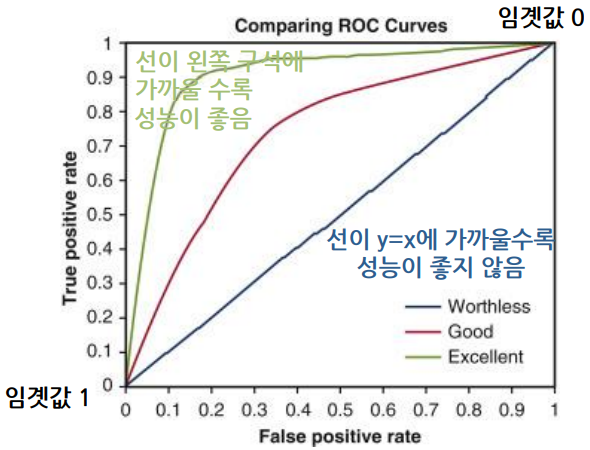

In [31]:
from sklearn.metrics import roc_curve

# 레이블 값이 1일때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)

# 반환된 임계값 배열에서 샘플로 데이터를 추출하되, 임곗값을 5 Step을 추출
# thresholds[0]dms max(예측확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0], 5)
print("샘플 추출을 위한 임곗값 배열의 index:", thr_index)
print("샘플 index로 추출한 임곗값:", np.round(thresholds[thr_index], 2), "\n")

# 5 step 단위로 추출된 임곗값에 따른 FPR, TPR 값
print("샘플 임곗값별 FPR:", np.round(fprs[thr_index], 3))
print("샘플 임곗값별 TPR:", np.round(tprs[thr_index], 3))

샘플 추출을 위한 임곗값 배열의 index: [ 1  6 11 16 21 26 31 36 41 46]
샘플 index로 추출한 임곗값: [0.94 0.73 0.62 0.52 0.44 0.28 0.15 0.14 0.13 0.12] 

샘플 임곗값별 FPR: [0.    0.008 0.025 0.076 0.127 0.254 0.576 0.61  0.746 0.847]
샘플 임곗값별 TPR: [0.016 0.492 0.705 0.738 0.803 0.885 0.902 0.951 0.967 1.   ]


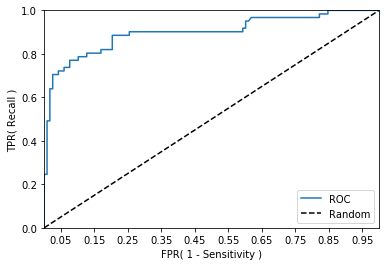

In [37]:
def roc_curve_plot(y_test, pred_proba_c1):
    #임곗값에 따른 FPR, TPR 값을 반환 받음
    fprs, tprs, thresholds =roc_curve(y_test, pred_proba_c1)
    
    # ROC Curve를 plot 곡선으로 그림
    plt.plot(fprs, tprs, label='ROC')
    # 가운데 대각선 직선을 그림
    plt.plot([0,1], [0,1], 'k--', label='Random')
    
    # FPR X축의 Scale을 0.1단위로 변경, X,Y 축명 설정 등
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Sensitivity )')
    plt.ylabel('TPR( Recall )')
    plt.legend()
    plt.show()
    
roc_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

In [38]:
from sklearn.metrics import roc_auc_score

pred_proba = lr_clf.predict_proba(X_test)[:, 1]
roc_score = roc_auc_score(y_test, pred_proba)
print("ROC AUC값: {0:.4f}".format(roc_score))

ROC AUC값: 0.8987


In [39]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    
    print("오차행렬\n", confusion)
    print("정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}, AUC:{4:.4f} \n".format(accuracy, precision, recall, f1, roc_auc))